### W207 Final Project - Forest Coverage Classification

#### Team members: Emily, Mohan, Stefania

The project and data is from https://www.kaggle.com/c/forest-cover-type-prediction/overview

We chose to use the K-Nearest Neighbors Classifier for the baseline.

## Introduction

For our final project we set out to create a model that could predict the forest cover type based on a dataset of cartographic variables. The datasets and full project description can be found on Kaggle (https://www.kaggle.com/c/forest-cover-type-prediction/overview). In order to find the best model, we followed these steps:
1. Download and clean up data
2. Create a baseline model to compare future iterations against
3. Perform exploratory data analysis on key variables
4. Define various pre-processing methods to run the models with
6. Test various models



In [82]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.metrics import confusion_matrix


# https://machinelearningmastery.com/how-to-fix-futurewarning-messages-in-scikit-learn/
# import warnings filter

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Download and separate data

In [83]:
# Read the data

df = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

# Rename columns
df.columns = ["Id", "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4",
    "Soil_Type1",  "Soil_Type2",  "Soil_Type3",  "Soil_Type4",  "Soil_Type5",  "Soil_Type6",
    "Soil_Type7",  "Soil_Type8",  "Soil_Type9",  "Soil_Type10", "Soil_Type11", "Soil_Type12",
    "Soil_Type13", "Soil_Type14", "Soil_Type15", "Soil_Type16", "Soil_Type17",
    "Soil_Type18", "Soil_Type19", "Soil_Type20", "Soil_Type21", "Soil_Type22",
    "Soil_Type23", "Soil_Type24", "Soil_Type25", "Soil_Type26", "Soil_Type27",
    "Soil_Type28", "Soil_Type29", "Soil_Type30", "Soil_Type31", "Soil_Type32",
    "Soil_Type33", "Soil_Type34", "Soil_Type35", "Soil_Type36", "Soil_Type37",
    "Soil_Type38", "Soil_Type39", "Soil_Type40", "Cover_Type"]


In [84]:
# Seperating features (X) and labels (y)
df = df.drop(["Id"], axis = 1)
test_data = test_data.drop(["Id"], axis = 1)
X, y = df.drop(["Cover_Type"], axis = 1), df["Cover_Type"]
train_data, dev_data, train_data_label, dev_data_label = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
print('train_data shape: ',train_data.shape)
print('train_data_labels shape: ',train_data_label.shape)
print('dev_data shape: ',dev_data.shape)
print('dev_data_labels shape: ',dev_data_label.shape)

train_data shape:  (12096, 54)
train_data_labels shape:  (12096,)
dev_data shape:  (3024, 54)
dev_data_labels shape:  (3024,)


In [85]:
train_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
14128,2942,151,27,376,191,1928,242,227,96,837,...,0,0,0,0,0,0,0,0,0,0
4425,2869,299,9,90,-11,1670,196,237,181,1460,...,0,0,0,0,0,0,0,0,0,0
909,2928,294,6,216,21,5075,204,239,174,1744,...,0,0,0,0,0,0,0,0,0,0
5123,2827,144,18,120,24,2255,242,234,114,1181,...,0,0,0,0,0,0,0,0,0,0
10901,2559,336,14,30,12,2006,187,220,171,524,...,0,0,0,0,0,0,0,0,0,0


## Baseline

For our baseline, we decided to use a simple KNN model. We iterated through a few values of K neighbors and found that the F1 value of the model dropped as K increased. 

k =  1 F1 of baseline model = 0.8374

k =  2 F1 of baseline model = 0.819

k =  4 F1 of baseline model = 0.8044

k =  6 F1 of baseline model = 0.7966

k =  8 F1 of baseline model = 0.78

k =  10 F1 of baseline model = 0.7728

k =  12 F1 of baseline model = 0.7571

k =  14 F1 of baseline model = 0.748

k =  16 F1 of baseline model = 0.7411

k =  18 F1 of baseline model = 0.7313

k =  20 F1 of baseline model = 0.7292



Text(0.5, 1.0, 'K value vs F1 Score')

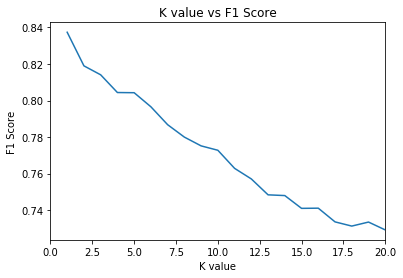

In [86]:
#create a KNN model with varying nearest neighbors as the baseline
#We chose to loop through values from 1 to 20 to assess the F1 scores the KNN algorithm
f1 = []
for i in range(1,21):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    knn_model.fit(train_data, train_data_label)
    y_dev_pred = knn_model.predict(dev_data)
    knn_f1 = round(metrics.f1_score(dev_data_label, y_dev_pred, average='macro'),4)
    f1.append(knn_f1)
    if (i == 1 or i % 2 == 0):
        print("k = ", i, "F1 of baseline model = " + str(knn_f1))
        print("")
        
plt.plot(range(1,21), f1)
plt.xlim(0,20)
plt.xlabel("K value")
plt.ylabel("F1 Score")
plt.title("K value vs F1 Score")

We can see that the F1 scores decline as K increases. We will use the baseline value of k = 1. The f1 score is .8374. This is pretty high accuracy for a baseline. KNN tries to find the closest match and our dataset includes datapoints that are patches of land. Nearby patches are likely have similar characteristics and tree cover types, so the high accuracy using KNN with K=1 makes sense.

### Confusion matrix

We decided to look at the confusion matrix for the baseline knn model (1-NN) to see what the biggest confusion was. 

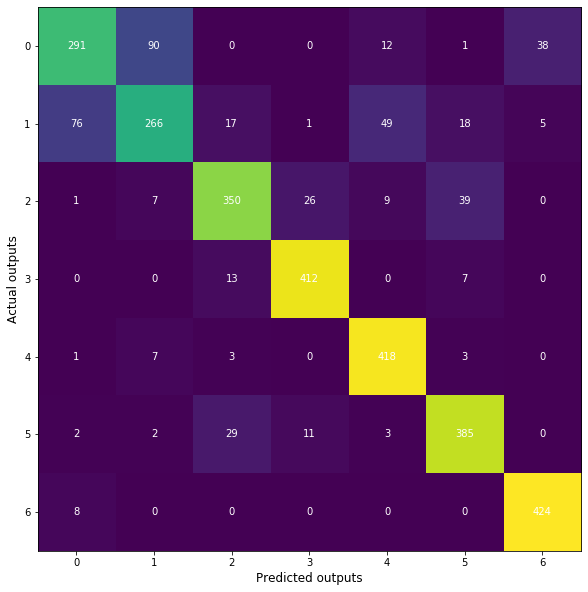

In [87]:
knn_model = KNeighborsClassifier(n_neighbors = 1)
knn_model.fit(train_data, train_data_label)
y_pred_label = knn_model.predict(dev_data)
y_pred_prob = knn_model.predict_proba(dev_data)

dev_data_label_list = list(dev_data_label)
        
cm = confusion_matrix(dev_data_label, y_pred_label)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(7))
ax.yaxis.set(ticks=range(7))
ax.set_ylim(6.5, -0.5)
for i in range(7):
    for j in range(7):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()



The baseline model seems to confuse mostly 1s and 2s with each other, i.e. it is having a hard time correctly classifying between cover type 1 (spruce/fir) and 2 (lodgepole pine). We explore this further in our EDA.

## EDA

There are twelve distinct features available to us:

1. **Elevation** - Elevation in meters 
2. **Aspect** - Aspect in degrees azimuth 
3. **Slope** - Slope in degrees 
4. **Horizontal_Distance_To_Hydrology** - Horzontal distance to nearest surface water features 
5. **Vertical_Distance_To_Hydrology** - Vertical distance to nearest surface water features 
6. **Horizontal_Distance_To_Roadways** - Horzontal distance to nearest roadway 
7. **Hillshade_9am (0 to 255 index)** - Hillshade distance at 9am, summer solstice 
8. **Hillshade_Noon (0 to 255 index)** - Hillshade index at noon, summer solstice 
9. **Hillshade_3pm (0 to 255 index)** - Hillshade index at 3pm, summer solstice 
10. **Horizontal_Distance_To_Fire_Points** - Horzontal distance to nearest wildfire ignition points 
11. **Wilderness_Area** (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation 
12. **Soil_Type** (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation 

Target is **Cover_Type** that designates forest cover type. The 7 cover types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

We started with a pair plot to see the distributions and correlations of the non-binary variables across the different cover types. We can see that elevation is a highly defining feature but there are significant overlaps across other variables that are harder to differentiate between cover types, at first glance. We can also see a strong correlation between hillshade 9am and hillshade 3pm, which is logical, we'll drop one of these columns with a preprocessor.

/Users/emilyrail/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/emilyrail/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


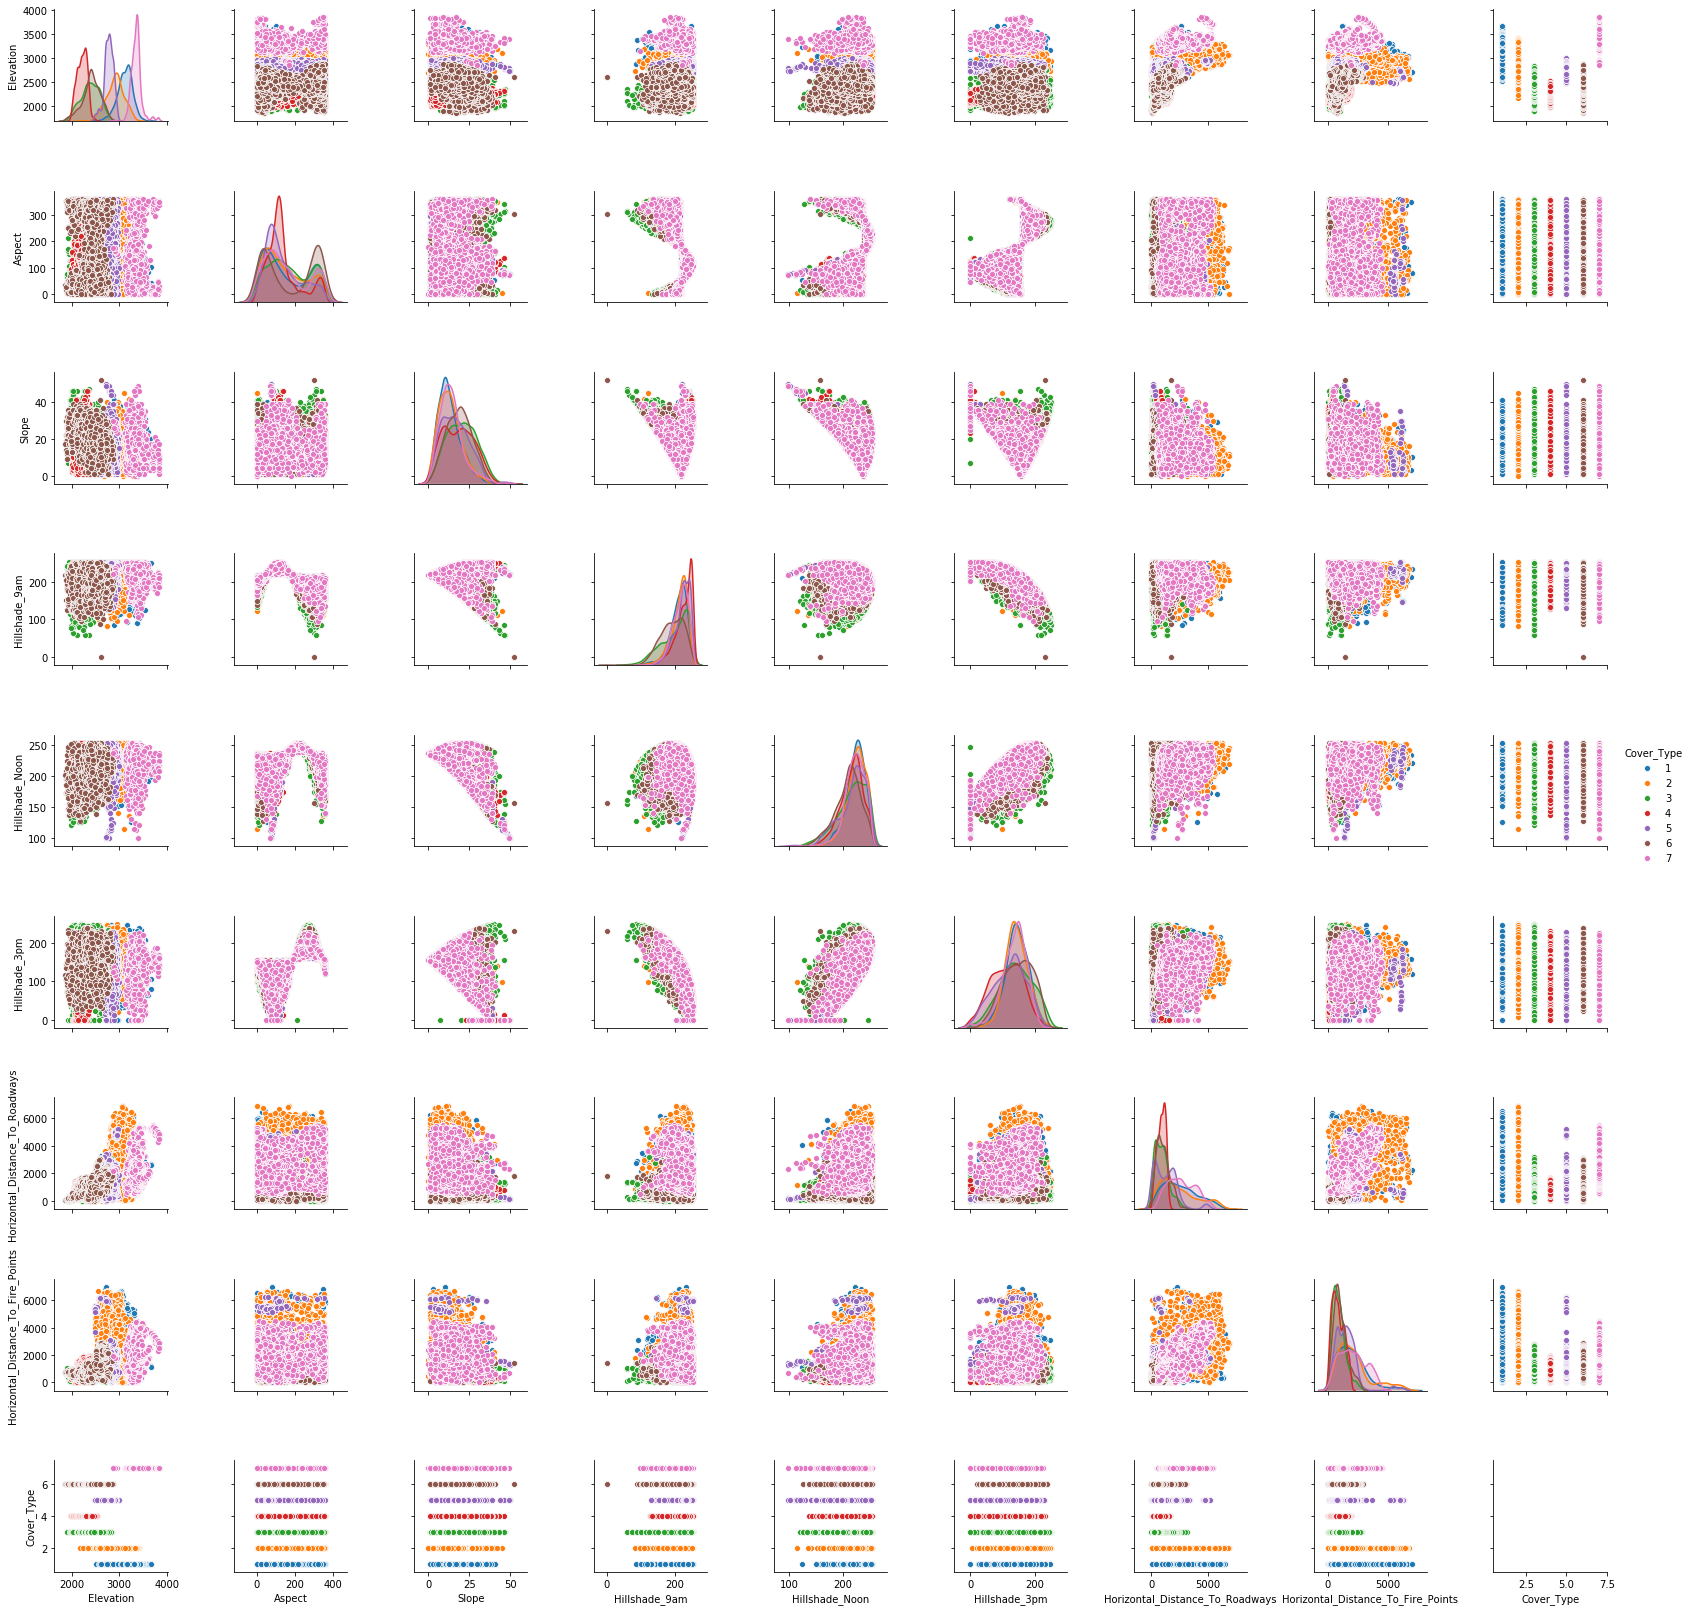

In [88]:
ex = df[["Elevation", "Aspect","Slope", \
         "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", \
         "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points", \
         "Cover_Type"]]

sns.pairplot(ex, hue = "Cover_Type")



Our baseline confusion matrix mostly confuses Cover Type 1 and 2, so we look at the differences between these Cover types. Here we can see a lot of very similar distributions for the two types. Elevation has the most significant variation between the two cover types.

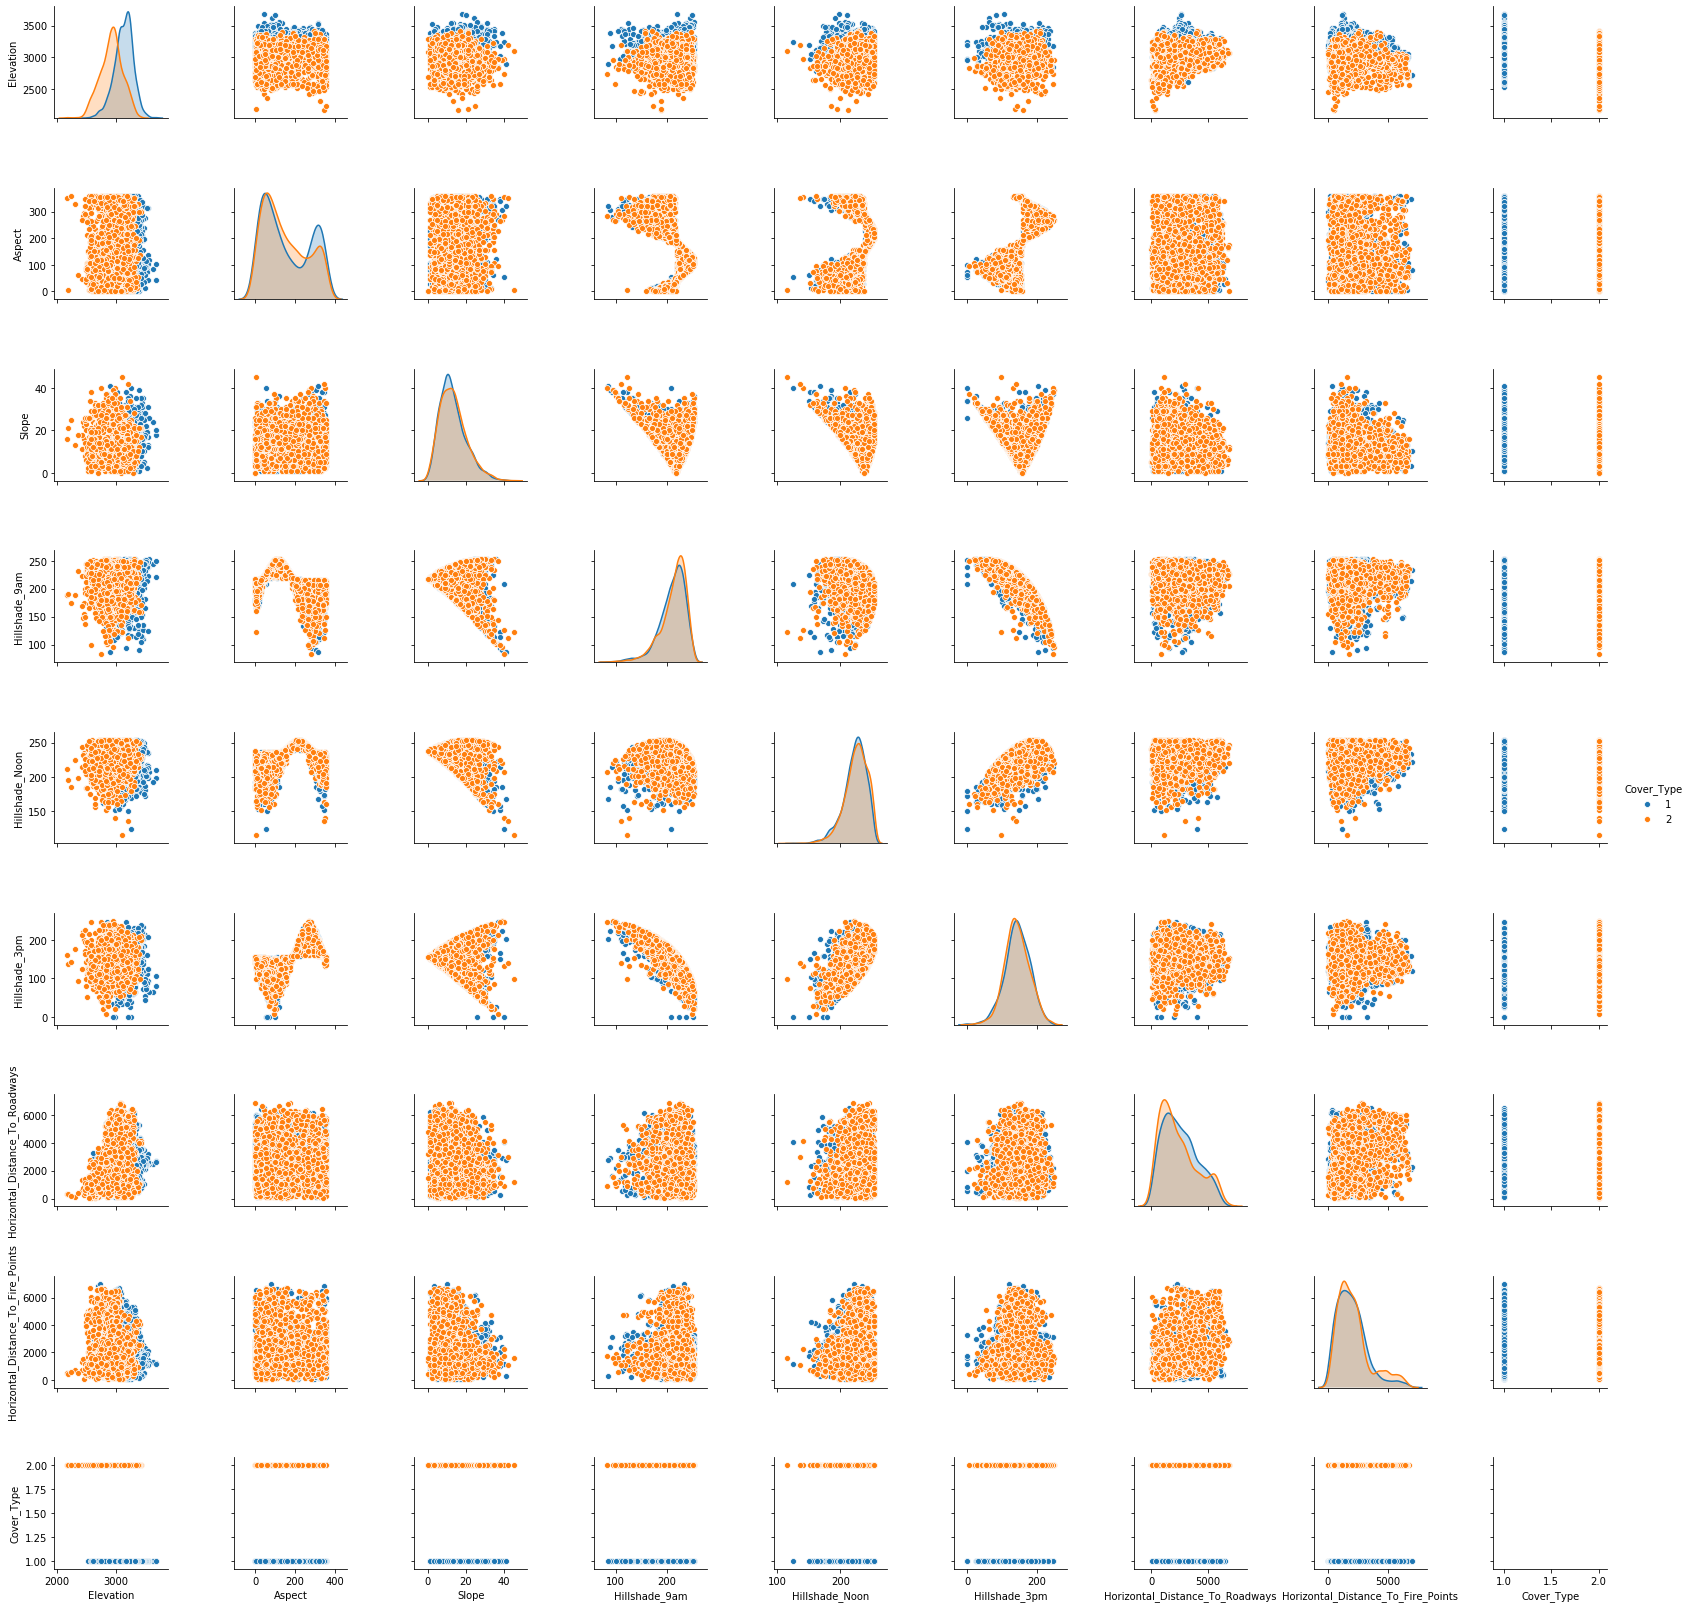

In [89]:
#Filter for cover types 1 and 2 only
def only_1_2(df1):
    limited_df = df1[(df1["Cover_Type"] == 1) | (df1["Cover_Type"] == 2)]
    return limited_df

ex_1_2 = only_1_2(ex)
sns.pairplot(ex_1_2, hue = "Cover_Type")


We also wanted to check that there is an even distribution of cover types in our data frame, this is correct as seen in the table below.

In [90]:
print("Full Dataframe: ")
print(df[["Cover_Type", "Elevation"]].groupby("Cover_Type").count())

Full Dataframe: 
            Elevation
Cover_Type           
1                2160
2                2160
3                2160
4                2160
5                2160
6                2160
7                2160


Here we looked at the elevation in one additional view, a boxplot, to see the differences in the distributions more clearly. 

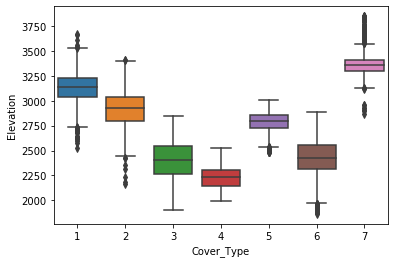

In [91]:
sns.boxplot(x=df['Cover_Type'], y=df["Elevation"], data=df)

Soil type is represented as a binary feature in the data set There are 40 different features for each soil type. We looked at the distribution of each type. There are very high counts of soil type 11 and 29 in the dataset. There are very low numbers of 7,8, 9 and 25. 

Text(0, 0.5, 'Count')

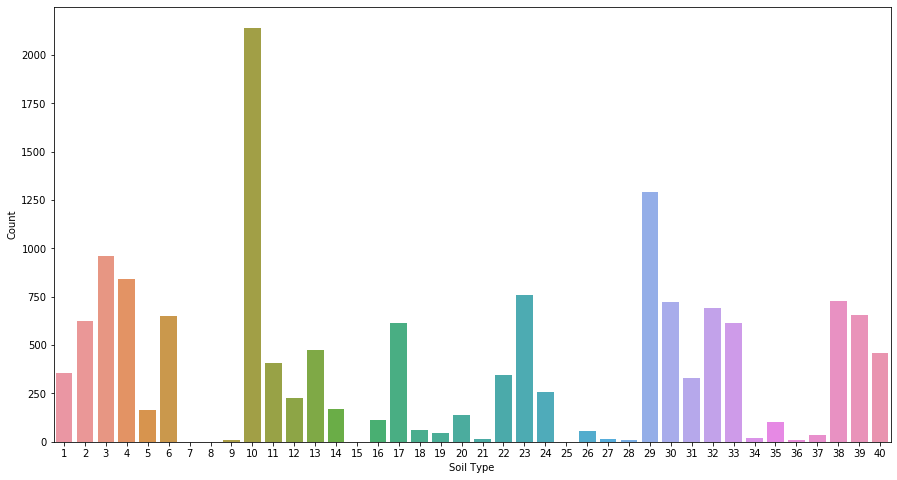

In [92]:
soil_df = df.loc[:,'Soil_Type1':'Soil_Type40']
soil_df.columns = range(1,41)
soil_series = soil_df.sum()

fig = plt.figure(figsize=(15, 8))

sns.barplot(x = soil_df.columns, y = soil_series)
plt.xlabel("Soil Type")
plt.ylabel("Count")

## Pre-processing Data

Our next step was to create a variety of preprocessing functions to run the data through. This way we could test the effect of each method on the training and dev accuracy. Each method is described below. 

### Normalize data

This preporcessor normalizes all values (subtract mean, divide by standard deviation) for non-categorical features.


In [93]:
def normalize_processor(df):
    df2 = df.copy()
    column_trans = ColumnTransformer(
    [('scaler', StandardScaler(),["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"])], remainder = "passthrough")
    dfnorm = column_trans.fit_transform(df2)
    dfnorm2 = pd.DataFrame(dfnorm, columns = df2.columns)
    return dfnorm2


### Condense binary columns

This preprocessor converts all the binary columns (i.e. soil type and wilderness area) and instead converts them to a single number that indicates what type they belong to. This helps reduce the number of columns the models are working with. 

In [94]:
def rem_binary(df):
    df2 = df.copy()
    wild_cols = df.loc[:, "Wilderness_Area1":"Wilderness_Area4"]
    soil_cols = df.loc[:, "Soil_Type1":"Soil_Type40"]
    def soil_factorize(row):
        for x in soil_cols.columns:
            if row[x] == 1:
                return int(x.split("e")[1])
    df2["Soil_Type"] = soil_cols.apply(soil_factorize, axis =1)
    def wild_factorize(row):
        for x in wild_cols.columns:
            if row[x] == 1:
                return int(x.split("Area")[1])
    df2["Wilderness_Area"] = wild_cols.apply(wild_factorize, axis =1)
    df2 = df2.drop(['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6',  'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Wilderness_Area1', 'Wilderness_Area2',
                  'Wilderness_Area3', 'Wilderness_Area4', 'Hillshade_3pm'], axis = 1)
    return df2

### Feature Engineering 

We attempt to reduce complexity by creating features by combining existing ones to  optimize our model’s performance. In order to make the best possible prediction we need to make the most of the features we are given. This involves combining two or more significant features, or categorizing different ones to make them more digestable for the model. 

1.  **Soil Type** – We observed in the Random Forest model that soil types were individually not very important features. So we decided to aggregate these soil types to create three new features based on their textures: `soil_stony`, `soil_rubbly`, and `soil_other`
<br/><br/>
2. **Hillshade Mean** - We are given the Hillshade index at 9:00 am, noon, and 3:00 pm. Given this information, and the fact that our prior model gave importance to these features, we added another feature `Hillshade_mean`, which represents the average of these three indices.
<br/><br/>
$$ HillshadeMean = \frac{Hillshade9am + Hillshade3pm + HillshadeNoon}{3} $$


<br/><br/>

The data cleaning, feature selection, preprocessing steps, and the feature engineering are all performed in the function `feat_eng`. This will be run on both the training and testing data, to make sure the data are in sync.

In [95]:
def feat_eng(df):
    # Adding Hillshade_Mean Feature
    df2 = df.copy()
    df2['Hillshade_Mean'] =  (df2['Hillshade_9am'] + df['Hillshade_Noon']  + df2['Hillshade_3pm']) / 3

    # Categorizing Soil Types by texture
    stony_col = ['Soil_Type1', 'Soil_Type2', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type12', 'Soil_Type18', 'Soil_Type22', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
    rubbly_col = ['Soil_Type3','Soil_Type4', 'Soil_Type5', 'Soil_Type10', 'Soil_Type11', 'Soil_Type13']
    other_col = ['Soil_Type8', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type23', 'Soil_Type35']
    df2['soil_stony'] = df2[stony_col].sum(axis=1)
    df2['soil_rubbly'] = df2[rubbly_col].sum(axis=1)
    df2['soil_other'] = df2[other_col].sum(axis=1)
    return df2

### Feature Selection with Random Forest

This preprocessor first gets the most important features based on a random forest of the train data and then is combined with a method to limit the dataframe to a certain number of important features.

In [96]:
# Important features of the random forest
RF_baseline = RandomForestClassifier(min_samples_split = 2, n_estimators = 200, max_depth = 20)
RF_baseline.fit(train_data, train_data_label) # Fitting the train data to the classifier 

importances = RF_baseline.feature_importances_
indices = np.argsort(importances)[::-1] 
print("Random Forest top impportant features")
importances_df = pd.DataFrame(columns=['Rank','Feature', 'Importance'])

for i in range(len(indices)):
    importance = np.around(importances[indices[i]],decimals=4)
    feature = train_data.columns[indices[i]]
    rank = i + 1
    importances_df.loc[i] = [rank, feature, importance]


# List the feature importances of the forest

importances_df[:15]

Random Forest top impportant features


,Rank,Feature,Importance
0,1,Elevation,0.2277
1,2,Horizontal_Distance_To_Roadways,0.0931
2,3,Horizontal_Distance_To_Fire_Points,0.0721
3,4,Horizontal_Distance_To_Hydrology,0.0617
4,5,Vertical_Distance_To_Hydrology,0.0504
5,6,Hillshade_9am,0.0496
6,7,Aspect,0.0472
7,8,Wilderness_Area4,0.0470
8,9,Hillshade_3pm,0.0445
9,10,Hillshade_Noon,0.0425


Processor that keeps only most important features

In [97]:
# returns a dataframe with subset of n most important features based on RF model
def rf_feature_selector(df2, n_features):
    df1 = df2[importances_df['Feature'][:n_features]]
    return df1

Elevation is exteremly significant, followed by Horizontal distance to Roadways, Fire points and Hydrology. 

## Pre-processed Data Sets

In [98]:
train_data_norm = normalize_processor(train_data)
train_data_rf_selector = rf_feature_selector(train_data,15)
train_data_feat_eng = feat_eng(train_data)
train_data_rem_bin = rem_binary(train_data)
train_data_norm_bin = rem_binary(normalize_processor(train_data))

dev_data_norm = normalize_processor(dev_data)
dev_data_rf_selector = rf_feature_selector(dev_data,15)
dev_data_feat_eng = feat_eng(dev_data)
dev_data_rem_bin = rem_binary(dev_data)
dev_data_norm_bin = rem_binary(normalize_processor(dev_data))



train_datasets = [train_data,  train_data_norm, train_data_rf_selector,  \
                  train_data_feat_eng, train_data_rem_bin, train_data_norm_bin]

dev_datasets = [dev_data, dev_data_norm, dev_data_rf_selector, \
                dev_data_feat_eng, dev_data_rem_bin, dev_data_norm_bin]

transformation_names = ["None",  "Normalize", "Feat Selector RF", "Feature Engineering", "Remove Binaries", "Normalized & No Bin"]


## Classification Models

We decided to try Decision Trees, Random Forests and KNN for our model. We also tried boosting through Extreme Gradient Boosting to account for wrong predictions. 
We did not use Naive Bayes because our features violate the independence assumption. We also determined that a non-linear model would likely perform better for our dataset.

### Decision Tree

In [99]:
#Creating a dataframe to compare model performance
index = np.array(range(80))
model_performance_df = pd.DataFrame(columns = ['Model Name', 'Train Time(s)', 'Prediction Time(s)', 'F1 Score', 'Pre-processor'], index = index)


In [100]:

from sklearn import tree
loc1 = 0
for ds in range(len(train_datasets)):
    clf = tree.DecisionTreeClassifier(max_depth = 20)
    start_train = time.time()
    clf = clf.fit(train_datasets[ds], train_data_label)
    end_time = time.time()
    train_time = str(round(end_time - start_train, 2))
    
    start_test = time.time()
    tree_pred= clf.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))
    accuracy = round(metrics.f1_score(dev_data_label, tree_pred, average="macro"),3)
    print("Transformation:", transformation_names[ds], "F1 Score = " + str(accuracy))
    model_performance_df.iloc[loc1] = ['Decision Trees', train_time, test_time, accuracy, transformation_names[ds]]
    loc1 +=1 

Transformation: None F1 Score = 0.788
Transformation: Normalize F1 Score = 0.787
Transformation: Feat Selector RF F1 Score = 0.768
Transformation: Feature Engineering F1 Score = 0.788
Transformation: Remove Binaries F1 Score = 0.781
Transformation: Normalized & No Bin F1 Score = 0.778


### Random Forest 

Random forests are an ensemble of decision trees; performance should be better as we are decreasing both the bias and variance.

In [101]:

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
RF_revised = RandomForestClassifier(min_samples_split = 2, n_estimators = 200, max_depth = 20)
for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
    start_train = time.time()
    RF_revised.fit(train_datasets[ds], train_data_label) # Fitting the train data to the classifier 
    end_train = time.time()
    train_time = str(round(end_train - start_train, 2))
    #predict = RF_revised.predict(test_data)
    start_test = time.time()
    RF_revised_pred = RF_revised.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))
    RF_revised_f1 = round(metrics.f1_score(dev_data_label, RF_revised_pred, average='macro'),3)
    print("Transformation:", transformation_names[ds])
    print("F1 score of revised Random Forest = " + str(RF_revised_f1))
    model_performance_df.iloc[loc1] = ['Random Forest', train_time, test_time, RF_revised_f1, transformation_names[ds]]

Transformation: None
F1 score of revised Random Forest = 0.847
Transformation: Normalize
F1 score of revised Random Forest = 0.845
Transformation: Feat Selector RF
F1 score of revised Random Forest = 0.849
Transformation: Feature Engineering
F1 score of revised Random Forest = 0.848
Transformation: Remove Binaries
F1 score of revised Random Forest = 0.857
Transformation: Normalized & No Bin
F1 score of revised Random Forest = 0.851


### Extra trees

Extra trees add a layer of randomization to decision tree modeling. It takes into account the whole learning sample.

We use GridSearchCV to find the optimal parameters. 
NOTE - this step takes time - so we ran it and commented it out.

`params = {'max_features': [0.8, 1], 'n_estimators': [10,20,50,100], 'max_depth': [10, 20, 30]}
clf = GridSearchCV(ExtraTreesClassifier(), params)
clf.fit(train_data, train_data_label)
print("Best parameters:", clf.best_params_) `

OUTPUT: Best parameters: {'max_depth': 30, 'max_features': 0.8, 'n_estimators': 100}

In [102]:
for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
    ExtraTree_clf = ExtraTreesClassifier(max_features=0.8, max_depth = 30, n_estimators=100)
    start_train = time.time()
    ExtraTree_clf.fit(train_datasets[ds], train_data_label) # Fitting the train data to the classifier 
    end_train = time.time()
    train_time = str(round(end_train - start_train, 2))
    # Make prediction on dev data
    start_test = time.time()
    pred = ExtraTree_clf.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))

    # Store metrics
    dev_f1 = round(metrics.f1_score(dev_data_label, pred, average='macro'), 3)
   # print("F1 Score for Extra Trees = " + str(dev_f1))
    model_performance_df.iloc[loc1] = ['Extra Trees', train_time, test_time, dev_f1, transformation_names[ds]]
    ##We need to adjust this DF to account for all the versions, unless we just get the max one
    
    print("Transformation:", transformation_names[ds], dev_f1)
   

Transformation: None 0.872
Transformation: Normalize 0.87
Transformation: Feat Selector RF 0.862
Transformation: Feature Engineering 0.87
Transformation: Remove Binaries 0.878
Transformation: Normalized & No Bin 0.882


### XGBoost (Extreme Gradient Boosting)

XGBoost uses gradient descent to compensate for some of the downsides of the previous decision tree model. It builds trees in series, and increases weights of incorrectly classified nodes, while decreasing those of the correctly classified. This uses the concept of "boosting" to continually improve a model by focusing on missclassifications.

We use GridSearchCV to find the optimal parameters. 
NOTE - this step takes time - so we ran it and commented it out.

`params = {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [50,100,200,500], 'max_depth': [10, 20, 30]}
clf = GridSearchCV(xgb.XGBClassifier(), params)
clf.fit(train_data, train_data_label)
print("Best parameters:", clf.best_params_) `

OUTPUT: Best parameters: {'max_depth': 10, 'Learning_rate': 0.1, 'n_estimators': 50}

In [103]:
for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
    xgb_clf = xgb.XGBClassifier(max_depth = 10, n_estimators = 50, learning_rate = 0.1)

    start_train = time.time()
    xgb_clf.fit(train_datasets[ds], train_data_label) # Fitting the train data to the classifier   
    end_train = time.time()
    train_time = str(round(end_train - start_train, 2))

    # Make prediction on dev data
    start_test = time.time()
    pred = xgb_clf.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))

    # Store metrics
    dev_f1 = round(metrics.f1_score(dev_data_label, pred, average='macro'), 3)
    print("Transformation:", transformation_names[ds], "F1 Score = " + str(dev_f1))
    model_performance_df.iloc[loc1] = ['Extreme Gradient Boost', train_time, test_time, dev_f1, transformation_names[ds]]
    

Transformation: None F1 Score = 0.84
Transformation: Normalize F1 Score = 0.837
Transformation: Feat Selector RF F1 Score = 0.831
Transformation: Feature Engineering F1 Score = 0.841
Transformation: Remove Binaries F1 Score = 0.842
Transformation: Normalized & No Bin F1 Score = 0.841


### Re-run KNN

Transformation: None 0.8374
Transformation: Normalize 0.7963
Transformation: Feat Selector RF 0.8374
Transformation: Feature Engineering 0.8367
Transformation: Remove Binaries 0.8364
Transformation: Normalized & No Bin 0.8049


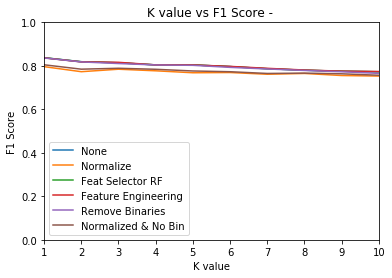

In [104]:
#create a KNN model with varying nearest neighbors as the baseline
#We chose to loop through values from 1 to 20 to assess the F1 scores the KNN algorithm


for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
    f1_2 = []
    for i in range(1,11):
        knn_model_2 = KNeighborsClassifier(n_neighbors = i)
        start_train = time.time()
        knn_model_2.fit(train_datasets[ds], train_data_label)
        end_train = time.time()
        train_time = str(round(end_train - start_train, 2))
        
        start_test = time.time()
        y_dev_pred = knn_model_2.predict(dev_datasets[ds])
        end_test = time.time()
        test_time = str(round(end_test - start_test, 2))
        knn_f1_2 = round(metrics.f1_score(dev_data_label, y_dev_pred, average='macro'),4)
        f1_2.append(knn_f1_2)
        #print("Transformation:", transformation_names[ds])
        #print("F1 score of baseline knn = " + str(knn_f1_2))
    max_f1 = max(f1_2)
    print("Transformation:", transformation_names[ds],max_f1)
    plt.plot(range(1,11), f1_2)
    plt.xlim(1,10)
    plt.ylim(0,1)
    plt.xlabel("K value")
    plt.ylabel("F1 Score")
    plt.title("K value vs F1 Score - ")#, transformation_names[ds])
    plt.legend(transformation_names)
    model_performance_df.iloc[loc1] = ['KNN', train_time, test_time, max_f1, transformation_names[ds]]
    


## Results Summary

In [105]:
model_performance_df.sort_values(by=['F1 Score'], ascending= False).dropna()


,Model Name,Train Time(s),Prediction Time(s),F1 Score,Pre-processor
17,Extra Trees,1.49,0.07,0.882,Normalized & No Bin
16,Extra Trees,1.49,0.07,0.878,Remove Binaries
12,Extra Trees,2.64,0.07,0.872,None
15,Extra Trees,2.82,0.07,0.87,Feature Engineering
13,Extra Trees,2.65,0.07,0.87,Normalize
14,Extra Trees,1.66,0.07,0.862,Feat Selector RF
10,Random Forest,3.39,0.12,0.857,Remove Binaries
11,Random Forest,3.41,0.12,0.851,Normalized & No Bin
8,Random Forest,3.35,0.13,0.849,Feat Selector RF
9,Random Forest,3.14,0.13,0.848,Feature Engineering


The best performing model is the Extra Trees classifier using the Normalize + Remove Binaries pre-processor. The accuracy is 0.878 which is a 4% improvement in accuracy over our baseline of .837 (KNN with No pre-processing)

### Confusion Matrix of best classifier

Get a Confusion Matrix for the best performing classifier, which is Extra Trees with Normalize+No Binaries pre-processor

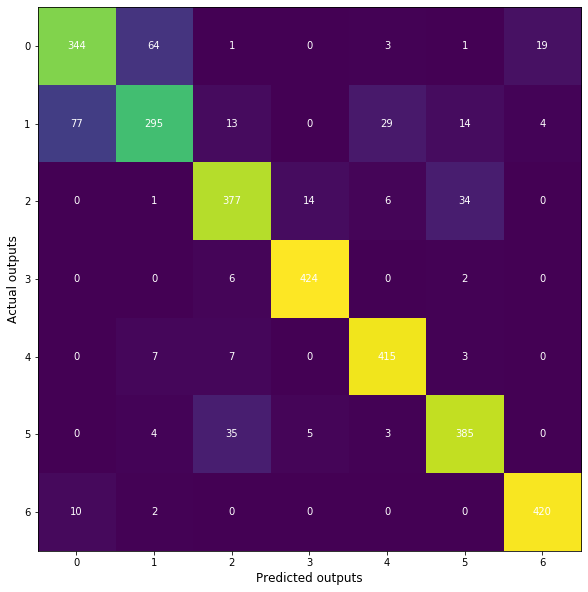

In [106]:
ExtraTree_clf = ExtraTreesClassifier(max_features=0.8, max_depth = 30, n_estimators=500)

ExtraTree_clf.fit(train_data_norm_bin, train_data_label) # Fitting the train data to the classifier   
    # Make prediction on dev data
    
pred = ExtraTree_clf.predict(dev_data_norm_bin)
    

#y_pred_prob = knn_model.predict_proba(dev_data)

        
cm = confusion_matrix(dev_data_label, pred)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(7))
ax.yaxis.set(ticks=range(7))
ax.set_ylim(6.5, -0.5)
for i in range(7):
    for j in range(7):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()



The best performing model still seems to mostly confuse 1s and 2s, but the number of misclassifications between these two is lower than what is was for our baseline. We looked at the accuracy of models that tried to classify between Cover Type 1 and 2 only to do an ensemble, but the accuracy of these was not better than the existing model.

In [107]:
test_norm_bin = rem_binary(normalize_processor(test_data))
test_pred = ExtraTree_clf.predict(test_norm_bin)

test_df = pd.DataFrame(np.unique(test_pred, return_counts=True))
test_df.columns = test_df.iloc[0]
test_df = test_df.iloc[1:]
test_df = test_df.transpose()
test_df.columns = ["Count"]
test_df["Cover_Type"] = ["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine", \
                         "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"]
test_df = test_df[["Cover_Type", "Count"]]

test_df

,Cover_Type,Count
0,,
1,Spruce/Fir,139234
2,Lodgepole Pine,250002
3,Ponderosa Pine,50195
4,Cottonwood/Willow,4151
5,Aspen,39837
6,Douglas-fir,58003
7,Krummholz,24470
